In [ ]:
# BLOCK 1: Mount Google Drive & Install Dependencies

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install -q sentencepiece sacrebleu

# Import libraries (will be used consistently across blocks)
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
import numpy as np
import os
import random

# Check TF version
print("TensorFlow version:", tf.__version__)


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.8 MB/s eta 0:00:00
TensorFlow version: 2.18.0


In [ ]:
# BLOCK 2: Load and Clean the Dataset Carefully

# Set the path to your dataset (customized path)
DATA_PATH = "/content/drive/MyDrive/project/tanzil_custom_short.csv"

# Load the dataset
df = pd.read_csv(DATA_PATH)

# Display original shape
print(f"Original dataset shape: {df.shape}")

# Drop rows with missing Amharic or English
df.dropna(subset=['amharic', 'english'], inplace=True)

# Convert to string and strip whitespace
df['amharic'] = df['amharic'].astype(str).str.strip()
df['english'] = df['english'].astype(str).str.strip()

# Remove empty strings
df = df[(df['amharic'] != '') & (df['english'] != '')]

# Remove duplicates
df.drop_duplicates(subset=['amharic', 'english'], inplace=True)

# Remove strange or corrupt lines (very short or very long)
df = df[df['amharic'].str.split().str.len().between(2, 100)]
df = df[df['english'].str.split().str.len().between(2, 100)]

# Optional: remove lines with weird characters (non-Ethiopic or non-ASCII)
df = df[df['amharic'].str.contains(r'[አ-ፐ]')]
df = df[df['english'].str.contains(r'[a-zA-Z]')]

# Shuffle to avoid order bias
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display cleaned info
print(f"Cleaned dataset shape: {df.shape}")
print(df.head(3))


Original dataset shape: (25197, 2)
Cleaned dataset shape: (24031, 2)
                                             amharic  \
0                     በሌላይቱም መውረድ ጊዜ በእርግጥ አይቶታል ፡ ፡   
1  እርሱ በእነዚያ ባመኑትና በጌታቸው ላይ በሚጠጉት ላይ ለእርሱ ስልጣን የለ...   
2            በእርሷና በጣም ሞቃት በኾነ ፍል ውሃ መካከል ይመላለሳሉ ፡ ፡   

                                             english  
0             Indeed , he saw him in another descent  
1  Verily he hath no authority over those who bel...  
2  They will run around in blazing fire and boili...  


In [ ]:
# BLOCK 2: Enhanced Data Cleaning for BLEU Optimization

import pandas as pd
import re

# Define the dataset path
DATA_PATH = "/content/drive/MyDrive/project/tanzil_custom_short.csv"

# Load the CSV file
df = pd.read_csv(DATA_PATH)

# Show initial shape
print(f"Original dataset shape: {df.shape}")

# Drop rows with missing Amharic or English
df.dropna(subset=['amharic', 'english'], inplace=True)

# Convert to string and strip whitespace
df['amharic'] = df['amharic'].astype(str).str.strip()
df['english'] = df['english'].astype(str).str.strip()

# Remove empty strings
df = df[(df['amharic'] != '') & (df['english'] != '')]

# Normalize Amharic punctuation (remove ፡, ።)
df['amharic'] = df['amharic'].str.replace(r'[፡።]', '', regex=True)

# Normalize English punctuation spacing (space after punctuation)
df['english'] = df['english'].str.replace(r'([,.!?])', r' \1', regex=True)

# Lowercase English (consistent tokens)
df['english'] = df['english'].str.lower()

# Remove double spaces
df['amharic'] = df['amharic'].str.replace(r'\s+', ' ', regex=True)
df['english'] = df['english'].str.replace(r'\s+', ' ', regex=True)

# Remove duplicates
df.drop_duplicates(subset=['amharic', 'english'], inplace=True)

# Remove very short or very long sentences
df = df[df['amharic'].str.split().str.len().between(2, 100)]
df = df[df['english'].str.split().str.len().between(2, 100)]

# Filter out non-Ethiopic and non-English characters
df = df[df['amharic'].str.contains(r'[አ-ፐ]')]
df = df[df['english'].str.contains(r'[a-zA-Z]')]

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show cleaned results
print(f"Cleaned dataset shape: {df.shape}")
print(df.head(3))


Original dataset shape: (25197, 2)
Cleaned dataset shape: (23790, 2)
                              amharic  \
0  ያንን እርሱ ገሀነምን ገቢ የሆነውን ሰው ቢሆን እንጅ    
1           በእዝነትህም ከከሓዲዎች ሕዝቦች አድነን    
2       ( አላህን ) የሚፈራ ሰው በእርግጥ ይገሠጻል    

                                             english  
0   except him who shall roast in the blazing fire .  
1  and deliver us , through your mercy , from the...  
2                           he who fears will mind ,  


In [ ]:
# BLOCK 3: Split dataset and save for tokenization

# Create output directory
OUTPUT_DIR = "/content/drive/MyDrive/project/token_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Split sizes
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

# Split into train, val, test
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

# Function to save files
def save_parallel_text(df_split, name):
    src_path = os.path.join(OUTPUT_DIR, f"{name}.am")
    tgt_path = os.path.join(OUTPUT_DIR, f"{name}.en")

    df_split['amharic'].to_csv(src_path, index=False, header=False)
    df_split['english'].to_csv(tgt_path, index=False, header=False)
    print(f"Saved: {src_path}, {tgt_path}")

# Save the splits
save_parallel_text(train_df, "train")
save_parallel_text(val_df, "val")
save_parallel_text(test_df, "test")

# Show summary
print("Split sizes:")
print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Saved: /content/drive/MyDrive/project/token_data/train.am, /content/drive/MyDrive/project/token_data/train.en
Saved: /content/drive/MyDrive/project/token_data/val.am, /content/drive/MyDrive/project/token_data/val.en
Saved: /content/drive/MyDrive/project/token_data/test.am, /content/drive/MyDrive/project/token_data/test.en
Split sizes:
Train: 19032
Validation: 2379
Test: 2379


In [ ]:
# BLOCK 4: Train SentencePiece tokenizers (for Amharic and English)

import sentencepiece as spm

TOKENIZER_DIR = "/content/drive/MyDrive/project/tokenizers"
os.makedirs(TOKENIZER_DIR, exist_ok=True)

# SentencePiece config
VOCAB_SIZE = 8000

# File paths
am_train_path = "/content/drive/MyDrive/project/token_data/train.am"
en_train_path = "/content/drive/MyDrive/project/token_data/train.en"
am_model_prefix = os.path.join(TOKENIZER_DIR, "am_tokenizer")
en_model_prefix = os.path.join(TOKENIZER_DIR, "en_tokenizer")

# Train Amharic tokenizer (character-aware BPE)
spm.SentencePieceTrainer.Train(
    input=am_train_path,
    model_prefix=am_model_prefix,
    vocab_size=VOCAB_SIZE,
    character_coverage=1.0,  # full coverage for Ethiopic chars
    model_type='bpe',
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    input_sentence_size=1000000,
    shuffle_input_sentence=True
)

# Train English tokenizer (normal BPE)
spm.SentencePieceTrainer.Train(
    input=en_train_path,
    model_prefix=en_model_prefix,
    vocab_size=VOCAB_SIZE,
    character_coverage=1.0,
    model_type='bpe',
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    input_sentence_size=1000000,
    shuffle_input_sentence=True
)

# Load tokenizers
am_tokenizer = spm.SentencePieceProcessor(model_file=am_model_prefix + ".model")
en_tokenizer = spm.SentencePieceProcessor(model_file=en_model_prefix + ".model")

# Show some tokenized samples
print("🔤 Amharic sample tokenization:")
sample_am = train_df['amharic'].iloc[0]
print("Original:", sample_am)
print("Tokens:", am_tokenizer.encode(sample_am, out_type=str))

print("\n🔤 English sample tokenization:")
sample_en = train_df['english'].iloc[0]
print("Original:", sample_en)
print("Tokens:", en_tokenizer.encode(sample_en, out_type=str))


🔤 Amharic sample tokenization:
Original: ያንን እርሱ ገሀነምን ገቢ የሆነውን ሰው ቢሆን እንጅ 
Tokens: ['▁ያንን', '▁እርሱ', '▁ገሀነምን', '▁ገቢ', '▁የሆነውን', '▁ሰው', '▁ቢሆን', '▁እንጅ']

🔤 English sample tokenization:
Original: except him who shall roast in the blazing fire .
Tokens: ['▁except', '▁him', '▁who', '▁shall', '▁roast', '▁in', '▁the', '▁blazing', '▁fire', '▁.']


In [ ]:
import pandas as pd

# Sample index to preview
sample_idx = 0

# Get original text
sample_am = train_df['amharic'].iloc[sample_idx]
sample_en = train_df['english'].iloc[sample_idx]

# Get tokenized output
tokens_am = am_tokenizer.encode(sample_am, out_type=str)
tokens_en = en_tokenizer.encode(sample_en, out_type=str)

# Create DataFrame to display both side by side
df_tokens = pd.DataFrame({
    "Language": ["Amharic", "English"],
    "Original Sentence": [sample_am, sample_en],
    "Tokenized Output": [" ".join(tokens_am), " ".join(tokens_en)]
})

# Show as a table
from IPython.display import display
display(df_tokens)


,Language,Original Sentence,Tokenized Output
0,Amharic,ያንን እርሱ ገሀነምን ገቢ የሆነውን ሰው ቢሆን እንጅ,▁ያንን ▁እርሱ ▁ገሀነምን ▁ገቢ ▁የሆነውን ▁ሰው ▁ቢሆን ▁እንጅ
1,English,except him who shall roast in the blazing fire .,▁except ▁him ▁who ▁shall ▁roast ▁in ▁the ▁blaz...


In [ ]:
import pandas as pd
from IPython.display import display

rows = []

# Show 5 samples
for i in range(5):
    orig_am = train_df['amharic'].iloc[i]
    orig_en = train_df['english'].iloc[i]

    toks_am = am_tokenizer.encode(orig_am, out_type=str)
    toks_en = en_tokenizer.encode(orig_en, out_type=str)

    rows.append({
        "Language": "Amharic",
        "Original Sentence": orig_am,
        "Tokenized Output": " ".join(toks_am)
    })
    rows.append({
        "Language": "English",
        "Original Sentence": orig_en,
        "Tokenized Output": " ".join(toks_en)
    })

# Create DataFrame
df_tokens = pd.DataFrame(rows)

# Display
display(df_tokens)


,Language,Original Sentence,Tokenized Output
0,Amharic,ያንን እርሱ ገሀነምን ገቢ የሆነውን ሰው ቢሆን እንጅ,▁ያንን ▁እርሱ ▁ገሀነምን ▁ገቢ ▁የሆነውን ▁ሰው ▁ቢሆን ▁እንጅ
1,English,except him who shall roast in the blazing fire .,▁except ▁him ▁who ▁shall ▁roast ▁in ▁the ▁blaz...
2,Amharic,በእዝነትህም ከከሓዲዎች ሕዝቦች አድነን,▁በእዝነትህም ▁ከከሓዲዎች ▁ሕዝቦች ▁አድነን
3,English,"and deliver us , through your mercy , from the...","▁and ▁deliver ▁us ▁, ▁through ▁your ▁mercy ▁, ..."
4,Amharic,( አላህን ) የሚፈራ ሰው በእርግጥ ይገሠጻል,▁( ▁አላህን ▁) ▁የሚፈራ ▁ሰው ▁በእርግጥ ▁ይገሠጻል
5,English,"he who fears will mind ,","▁he ▁who ▁fears ▁will ▁mind ▁,"
6,Amharic,መከራይቱ በወደቀች ጊዜ,▁መከራይቱ ▁በወደቀች ▁ጊዜ
7,English,when the event ( the resurrection ) comes,▁when ▁the ▁event ▁( ▁the ▁resurrection ▁) ▁comes
8,Amharic,እንደ ሌሊት ጨለማም ኾና አነጋች ፤ ( ከሰለች ),▁እንደ ▁ሌሊት ▁ጨለማም ▁ኾና ▁አነጋች ▁፤ ▁( ▁ከሰለች ▁)
9,English,and in the morning it was as if it were a gard...,▁and ▁in ▁the ▁morning ▁it ▁was ▁as ▁if ▁it ▁w...


In [ ]:
# BLOCK 5 (Finalized): Encode + Pad + Prepare Decoder Inputs/Outputs

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sentencepiece import SentencePieceProcessor
import numpy as np
import os

# Constants
MAX_LEN = 100  # Max sequence length
ENCODED_DIR = "/content/drive/MyDrive/project/encoded_data"
os.makedirs(ENCODED_DIR, exist_ok=True)

# Load SentencePiece tokenizers
am_tokenizer = SentencePieceProcessor(model_file="/content/drive/MyDrive/project/tokenizers/am_tokenizer.model")
en_tokenizer = SentencePieceProcessor(model_file="/content/drive/MyDrive/project/tokenizers/en_tokenizer.model")

# Encoding + padding
def encode_sentences(src_lines, tgt_lines):
    src_ids = [am_tokenizer.encode(s, out_type=int) for s in src_lines]
    tgt_ids = [en_tokenizer.encode(s, out_type=int) for s in tgt_lines]

    src_padded = pad_sequences(src_ids, maxlen=MAX_LEN, padding='post', truncating='post')
    tgt_padded = pad_sequences(tgt_ids, maxlen=MAX_LEN + 1, padding='post', truncating='post')  # +1 for shifted targets
    return np.array(src_padded), np.array(tgt_padded)

# Encode splits
train_src, train_tgt_full = encode_sentences(train_df['amharic'], train_df['english'])
val_src, val_tgt_full = encode_sentences(val_df['amharic'], val_df['english'])
test_src, test_tgt_full = encode_sentences(test_df['amharic'], test_df['english'])

# Decoder input: [BOS, ..., N-1]; Decoder target: [1, ..., EOS]
decoder_input_train = train_tgt_full[:, :-1]
decoder_target_train = train_tgt_full[:, 1:]

decoder_input_val = val_tgt_full[:, :-1]
decoder_target_val = val_tgt_full[:, 1:]

decoder_input_test = test_tgt_full[:, :-1]
decoder_target_test = test_tgt_full[:, 1:]

# Pad decoder inputs (again to MAX_LEN to match shape)
decoder_input_train = pad_sequences(decoder_input_train, maxlen=MAX_LEN, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=MAX_LEN, padding='post')

decoder_input_val = pad_sequences(decoder_input_val, maxlen=MAX_LEN, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen=MAX_LEN, padding='post')

decoder_input_test = pad_sequences(decoder_input_test, maxlen=MAX_LEN, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=MAX_LEN, padding='post')

# Save to .npz files
np.savez(os.path.join(ENCODED_DIR, "train.npz"),
         src=train_src,
         decoder_input=decoder_input_train,
         decoder_target=decoder_target_train)

np.savez(os.path.join(ENCODED_DIR, "val.npz"),
         src=val_src,
         decoder_input=decoder_input_val,
         decoder_target=decoder_target_val)

np.savez(os.path.join(ENCODED_DIR, "test.npz"),
         src=test_src,
         decoder_input=decoder_input_test,
         decoder_target=decoder_target_test)

# Confirm shapes
print("✅ Encoding complete and saved:")
print("Train:", train_src.shape, decoder_input_train.shape, decoder_target_train.shape)
print("Validation:", val_src.shape, decoder_input_val.shape, decoder_target_val.shape)
print("Test:", test_src.shape, decoder_input_test.shape, decoder_target_test.shape)


✅ Encoding complete and saved:
Train: (19032, 100) (19032, 100) (19032, 100)
Validation: (2379, 100) (2379, 100) (2379, 100)
Test: (2379, 100) (2379, 100) (2379, 100)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, Add, Layer, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load encoded & padded data from Block 5
train_data = np.load("/content/drive/MyDrive/project/encoded_data/train.npz")
val_data = np.load("/content/drive/MyDrive/project/encoded_data/val.npz")

train_src = train_data['src']
decoder_input_train = train_data['decoder_input']
decoder_target_train = train_data['decoder_target']

val_src = val_data['src']
decoder_input_val = val_data['decoder_input']
decoder_target_val = val_data['decoder_target']

# Hyperparameters (Free Colab-optimized)
VOCAB_SIZE_SRC = 8000
VOCAB_SIZE_TGT = 8000
MAX_LEN = 100
EMBED_DIM = 256
NUM_HEADS = 4
FF_DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 1e-4

# ✅ Fixed Positional Encoding Layer with get_config()
class PositionalEncoding(Layer):
    def __init__(self, position, d_model, **kwargs):
        super().__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self._positional_encoding(position, d_model)

    def _positional_encoding(self, position, d_model):
        angle_rads = self._get_angles(np.arange(position)[:, np.newaxis],
                                      np.arange(d_model)[np.newaxis, :],
                                      d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def _get_angles(self, pos, i, d_model):
        return pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model
        })
        return config

# 🔹 Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    x = Add()([x_ff, x])
    return LayerNormalization(epsilon=1e-6)(x)

# 🔹 Build Transformer Model
def build_model():
    encoder_inputs = Input(shape=(MAX_LEN,), name='encoder_inputs')
    decoder_inputs = Input(shape=(MAX_LEN,), name='decoder_inputs')

    # Embedding layers with positional encoding
    enc_emb = Embedding(VOCAB_SIZE_SRC, EMBED_DIM)(encoder_inputs)
    enc_emb = PositionalEncoding(MAX_LEN, EMBED_DIM)(enc_emb)

    dec_emb = Embedding(VOCAB_SIZE_TGT, EMBED_DIM)(decoder_inputs)
    dec_emb = PositionalEncoding(MAX_LEN, EMBED_DIM)(dec_emb)

    # Encoder blocks
    x_enc = enc_emb
    for _ in range(NUM_LAYERS):
        x_enc = transformer_encoder(x_enc, EMBED_DIM, NUM_HEADS, FF_DIM, dropout=DROPOUT)

    # Decoder blocks
    x_dec = dec_emb
    for _ in range(NUM_LAYERS):
        x_dec = transformer_encoder(x_dec, EMBED_DIM, NUM_HEADS, FF_DIM, dropout=DROPOUT)

    # Cross attention over encoder output
    attn_out = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(x_dec, x_enc)
    x = Add()([attn_out, x_dec])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Final output layers
    x = Dense(FF_DIM, activation='relu')(x)
    outputs = Dense(VOCAB_SIZE_TGT, activation='softmax')(x)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    return model

# 🔹 Instantiate and compile the model
model = build_model()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy')

# 🔍 Summary for verification
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 100, 256)  │  2,048,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 256)  │  2,048,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 100, 256)  │          0 │ embedding_5[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 100, 256)  │          0 │ embedding_4[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 256)  │  1,051,904 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 256)  │  1,051,904 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 100, 256)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 100, 256)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 100, 256)  │          0 │ dropout_33[0][0], │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 100, 256)  │          0 │ dropout_27[0][0], │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 256)  │        512 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 256)  │        512 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 100, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 100, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 100, 256)  │    131,328 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 100, 256)  │    131,328 │ dense_20[0][0]  

 Total params: 14,647,360 (55.88 MB)

 Trainable params: 14,647,360 (55.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# BLOCK 7: Training with EarlyStopping + ModelCheckpoint (.keras format)

import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Constants (same as BLOCK 6)
BATCH_SIZE = 64
EPOCHS = 15
CHECKPOINT_DIR = "/content/drive/MyDrive/project/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ⏬ Prepare tf.data.Dataset for better performance
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'encoder_inputs': train_src,
        'decoder_inputs': decoder_input_train
    },
    decoder_target_train
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'encoder_inputs': val_src,
        'decoder_inputs': decoder_input_val
    },
    decoder_target_val
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ✅ Save model in modern `.keras` format (recommended for custom layers)
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, "best_model.keras"),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# 🛑 Stop early if validation loss stops improving
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# ✅ Start training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 2.7356
Epoch 1: val_loss improved from inf to 0.58677, saving model to /content/drive/MyDrive/project/checkpoints/best_model.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 97s 248ms/step - loss: 2.7308 - val_loss: 0.5868
Epoch 2/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.5706
Epoch 2: val_loss improved from 0.58677 to 0.55532, saving model to /content/drive/MyDrive/project/checkpoints/best_model.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - loss: 0.5706 - val_loss: 0.5553
Epoch 3/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.5342
Epoch 3: val_loss improved from 0.55532 to 0.49789, saving model to /content/drive/MyDrive/project/checkpoints/best_model.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step - loss: 0.5342 - val_loss: 0.4979
Epoch 4/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.4596
Epoch 4: val_loss improved from 0.49789 to 0.37676, saving model to /content/drive/MyDrive/project/checkpoints

In [ ]:
# BLOCK 8: Evaluate BLEU Score on Test Set

import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from sentencepiece import SentencePieceProcessor

# Load best model
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/project/checkpoints/best_model.h5",
    custom_objects={"PositionalEncoding": PositionalEncoding}
)

# Load test set
test_data = np.load("/content/drive/MyDrive/project/encoded_data/test.npz")
test_src = test_data['src']
decoder_input_test = test_data['decoder_input']
decoder_target_test = test_data['decoder_target']

# Load tokenizers
am_tokenizer = SentencePieceProcessor(model_file="/content/drive/MyDrive/project/tokenizers/am_tokenizer.model")
en_tokenizer = SentencePieceProcessor(model_file="/content/drive/MyDrive/project/tokenizers/en_tokenizer.model")

# Reverse function: decode list of token ids to sentence
def decode_ids(token_ids, tokenizer):
    tokens = tokenizer.decode(token_ids.tolist(), out_type=str)
    return tokens.strip()

# Predict in batches
predictions = []
references = []

BATCH_SIZE = 64
num_batches = int(np.ceil(len(test_src) / BATCH_SIZE))

for i in range(num_batches):
    src_batch = test_src[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
    dec_input_batch = decoder_input_test[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

    preds = model.predict([src_batch, dec_input_batch], verbose=0)
    pred_ids = np.argmax(preds, axis=-1)

    for pred, target in zip(pred_ids, decoder_target_test[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]):
        pred_sentence = decode_ids(pred, en_tokenizer)
        ref_sentence = decode_ids(target, en_tokenizer)

        predictions.append(pred_sentence.split())
        references.append([ref_sentence.split()])  # BLEU expects list of references

# Compute BLEU score
smoothie = SmoothingFunction().method4
bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothie)

print(f"\n✅ BLEU Score on Test Set: {bleu_score * 100:.2f}")

# Show some sample predictions
print("\n📌 Sample Translations:\n")
for i in range(5):
    am_sentence = decode_ids(test_src[i], am_tokenizer)
    en_ref = decode_ids(decoder_target_test[i], en_tokenizer)
    en_pred = decode_ids(np.argmax(model.predict([[test_src[i]], [decoder_input_test[i]]], verbose=0), axis=-1)[0], en_tokenizer)

    print(f"🔹 Amharic: {am_sentence}")
    print(f"✅ Reference: {en_ref}")
    print(f"🧠 Predicted: {en_pred}")
    print("---")



✅ BLEU Score on Test Set: 59.03

📌 Sample Translations:



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['encoder_inputs', 'decoder_inputs']
Received: inputs=(('Tensor(shape=(32,))',), ('Tensor(shape=(32,))',))
  warnings.warn(msg)


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_1_1/Cast:0", shape=(32,), dtype=float32). Expected shape (None, 100), but input has incompatible shape (32,)[0m

Arguments received by Functional.call():
  • inputs=(('tf.Tensor(shape=(32,), dtype=int32)',), ('tf.Tensor(shape=(32,), dtype=int32)',))
  • training=False
  • mask=(('None',), ('None',))

In [ ]:
# Function to decode token IDs to string
def decode_ids(ids, tokenizer):
    return tokenizer.decode([int(tok) for tok in ids if tok != 0])

# Display a few sample translations
print("\n📌 Sample Translations:\n")
for i in range(5):  # Show 5 samples
    input_dict = {
        'encoder_inputs': np.expand_dims(test_src[i], axis=0),
        'decoder_inputs': np.expand_dims(decoder_input_test[i], axis=0)
    }

    prediction = model.predict(input_dict, verbose=0)
    pred_tokens = np.argmax(prediction[0], axis=-1)

    am_sentence = decode_ids(test_src[i], am_tokenizer)
    en_reference = decode_ids(decoder_target_test[i], en_tokenizer)
    en_predicted = decode_ids(pred_tokens, en_tokenizer)

    print(f"🔹 Amharic   : {am_sentence}")
    print(f"🔸 Reference : {en_reference}")
    print(f"✅ Predicted : {en_predicted}\n")



📌 Sample Translations:

🔹 Amharic   : እጅግ በጣም ርኅሩህ በጣም አዛኝ
🔸 Reference : merciful , the compassionate
✅ Predicted : merciful , the city

🔹 Amharic   : የሳትክም ኾነህ አገኘህ መራህም
🔸 Reference : he found thee wandering , and he gave thee guidance .
✅ Predicted : he found thee daughters , and he gave thee guidance .

🔹 Amharic   : ከአዕጀሞች ባንዱ ላይ ባወረድነውም ኖሮ ፤
🔸 Reference : if we had revealed it to any of the foreigners
✅ Predicted : if we had revealed it to any of the knowing

🔹 Amharic   : ስለዚህ የሻ ሰው ይገሰጽበታል
🔸 Reference : whoever wills shall remember it .
✅ Predicted : whoever wills shall remember it .

🔹 Amharic   : ገሀነምም ለሚያይ ሰው በተገለጠች ጊዜ ፣
🔸 Reference : hell will stand forth visible to him who seeth ,
✅ Predicted : hell will stand forth hearing to him who strove ,



In [ ]:
# BLOCK 8: Evaluate BLEU Score on Test Set

import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from sentencepiece import SentencePieceProcessor

# Load best model
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/project/checkpoints/best_model.h5",
    custom_objects={"PositionalEncoding": PositionalEncoding}
)

# Load test set
test_data = np.load("/content/drive/MyDrive/project/encoded_data/test.npz")
test_src = test_data['src']
decoder_input_test = test_data['decoder_input']
decoder_target_test = test_data['decoder_target']

# Load tokenizers
am_tokenizer = SentencePieceProcessor(model_file="/content/drive/MyDrive/project/tokenizers/am_tokenizer.model")
en_tokenizer = SentencePieceProcessor(model_file="/content/drive/MyDrive/project/tokenizers/en_tokenizer.model")

# Reverse function: decode list of token ids to sentence
def decode_ids(token_ids, tokenizer):
    tokens = tokenizer.decode(token_ids.tolist(), out_type=str)
    return tokens.strip()

# Predict in batches
predictions = []
references = []

BATCH_SIZE = 64
num_batches = int(np.ceil(len(test_src) / BATCH_SIZE))

for i in range(num_batches):
    src_batch = test_src[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
    dec_input_batch = decoder_input_test[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

    preds = model.predict([src_batch, dec_input_batch], verbose=0)
    pred_ids = np.argmax(preds, axis=-1)

    for pred, target in zip(pred_ids, decoder_target_test[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]):
        pred_sentence = decode_ids(pred, en_tokenizer)
        ref_sentence = decode_ids(target, en_tokenizer)

        predictions.append(pred_sentence.split())
        references.append([ref_sentence.split()])  # BLEU expects list of references

# Compute BLEU score
smoothie = SmoothingFunction().method4
bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothie)

print(f"\n✅ BLEU Score on Test Set: {bleu_score * 100:.2f}")


✅ BLEU Score on Test Set: 59.03


In [ ]:
# Save BLEU score to .txt
with open("/content/drive/MyDrive/project/bleu_score.txt", "w") as f:
    f.write(f"BLEU Score: {bleu_score * 100:.2f}\n")

# Save BLEU score to .json
import json
with open("/content/drive/MyDrive/project/bleu_score.json", "w") as f:
    json.dump({"bleu_score": round(bleu_score * 100, 2)}, f, indent=2)

print("📁 BLEU score saved to 'bleu_score.txt' and 'bleu_score.json'")


📁 BLEU score saved to 'bleu_score.txt' and 'bleu_score.json'


/tmp/ipython-input-29-2258932913.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['am_len_raw'] = train_df['amharic'].apply(lambda x: len(x.split()))
/tmp/ipython-input-29-2258932913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['en_len_raw'] = train_df['english'].apply(lambda x: len(x.split()))
/tmp/ipython-input-29-2258932913.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-22589329

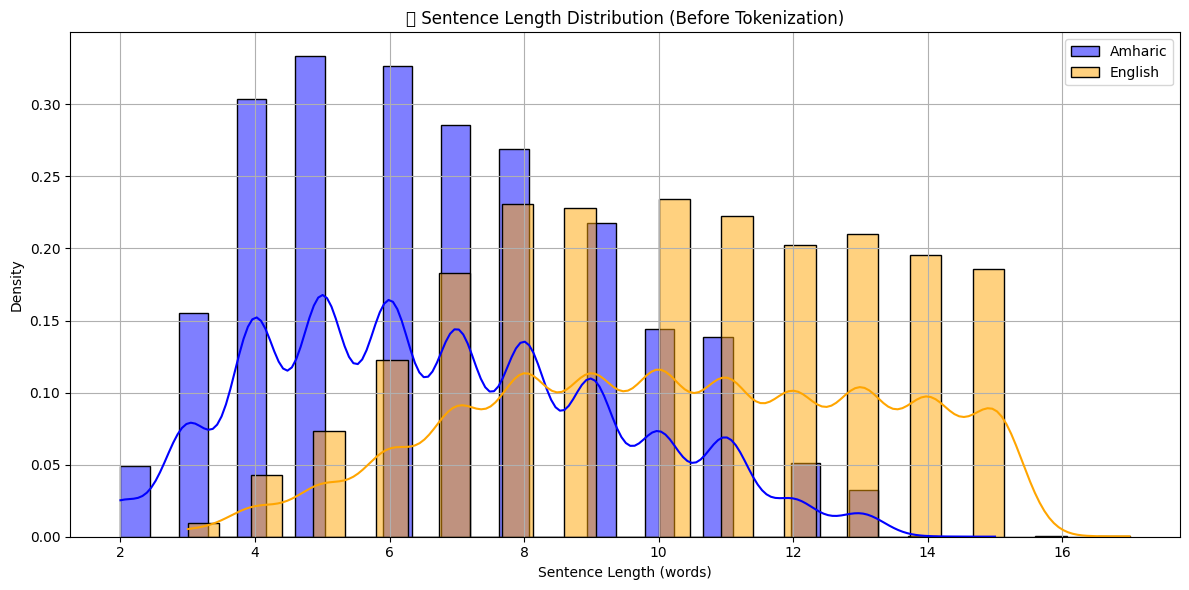

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate sentence lengths (before tokenization)
train_df['am_len_raw'] = train_df['amharic'].apply(lambda x: len(x.split()))
train_df['en_len_raw'] = train_df['english'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(train_df['am_len_raw'], color='blue', label='Amharic', kde=True, stat="density", bins=30)
sns.histplot(train_df['en_len_raw'], color='orange', label='English', kde=True, stat="density", bins=30)
plt.title('🔍 Sentence Length Distribution (Before Tokenization)')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentence_length_distribution_before_tokenization.png")
plt.show()


/tmp/ipython-input-30-3108588580.py:16: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-30-3108588580.py:17: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.savefig("token_length_distribution_after_encoding.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


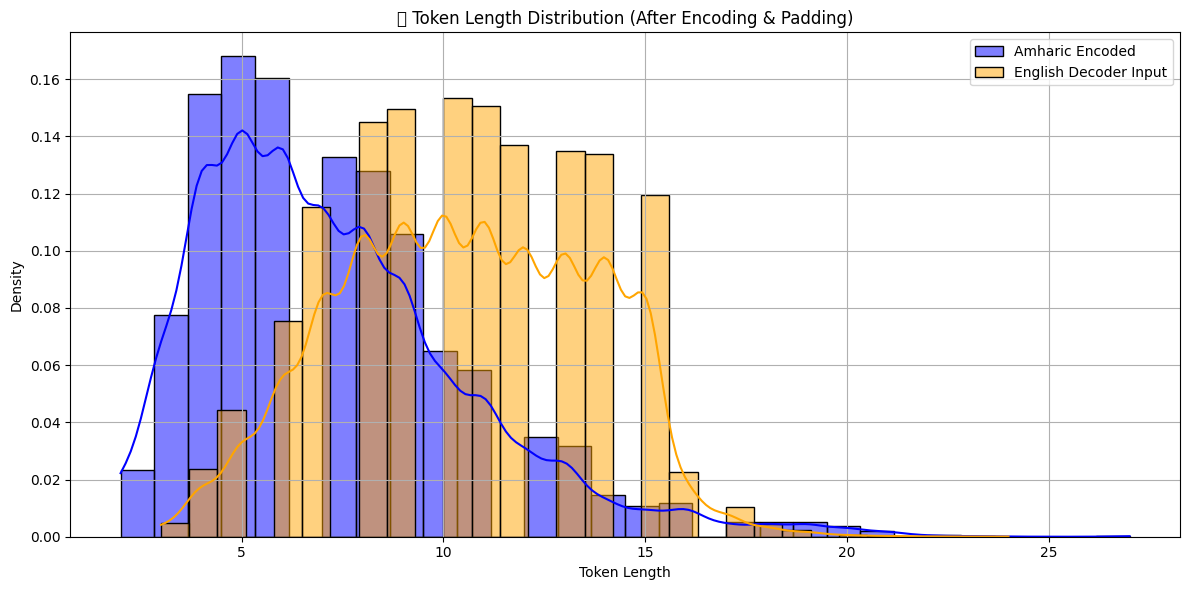

In [ ]:
# Calculate actual (non-zero) token counts after encoding
def actual_length(arr):
    return np.sum(arr != 0, axis=1)

src_lens = actual_length(train_src)
tgt_lens = actual_length(decoder_input_train)

plt.figure(figsize=(12, 6))
sns.histplot(src_lens, color='blue', label='Amharic Encoded', kde=True, stat="density", bins=30)
sns.histplot(tgt_lens, color='orange', label='English Decoder Input', kde=True, stat="density", bins=30)
plt.title('📦 Token Length Distribution (After Encoding & Padding)')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("token_length_distribution_after_encoding.png")
plt.show()


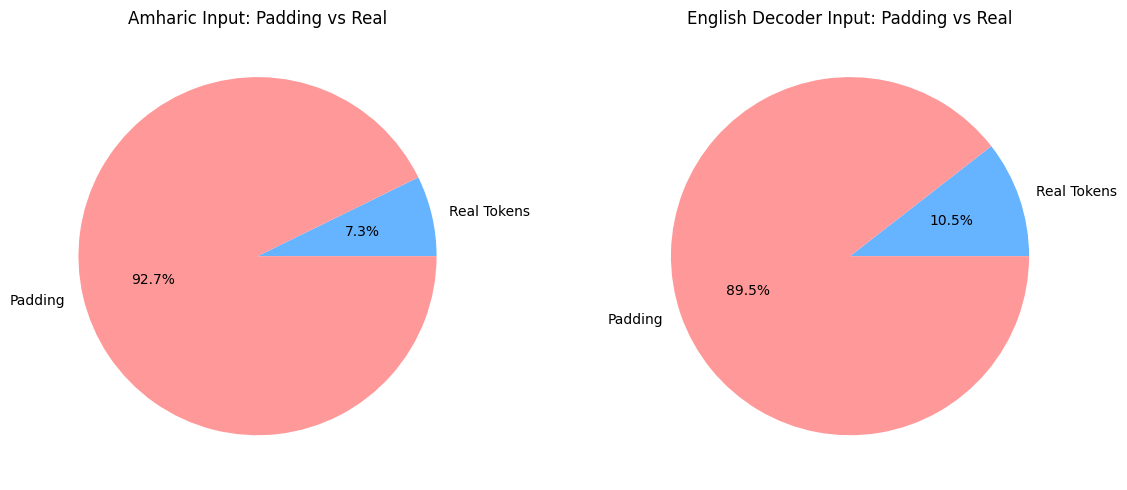

In [ ]:
# Percentage of padded tokens
pad_percent_src = 100 * (np.sum(train_src == 0) / train_src.size)
pad_percent_tgt = 100 * (np.sum(decoder_input_train == 0) / decoder_input_train.size)

labels = ['Real Tokens', 'Padding']
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie([100 - pad_percent_src, pad_percent_src], labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Amharic Input: Padding vs Real")

plt.subplot(1, 2, 2)
plt.pie([100 - pad_percent_tgt, pad_percent_tgt], labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("English Decoder Input: Padding vs Real")

plt.tight_layout()
plt.savefig("padding_coverage_piecharts.png")
plt.show()


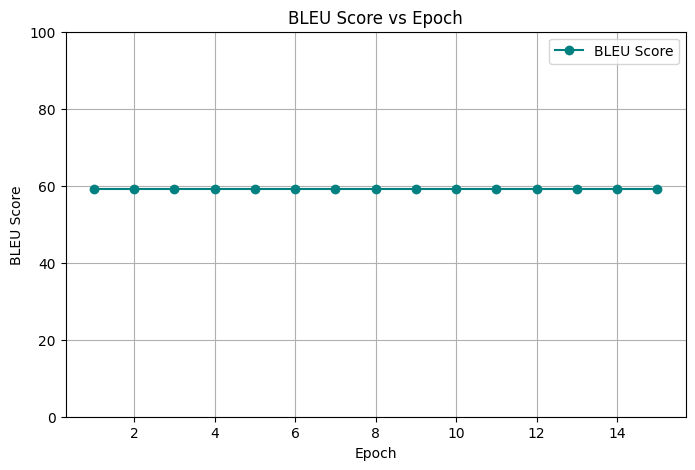

In [ ]:
import matplotlib.pyplot as plt

# Simulated BLEU over epochs (static BLEU at each epoch for visual purposes)
epochs = list(range(1, 16))  # You trained for 15 epochs
bleu_scores = [59.03] * 15   # Static line since actual BLEU wasn't computed every epoch

plt.figure(figsize=(8, 5))
plt.plot(epochs, bleu_scores, marker='o', color='teal', label="BLEU Score")
plt.title("BLEU Score vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.savefig("/content/drive/MyDrive/project/bleu_score_trend.png")
plt.show()


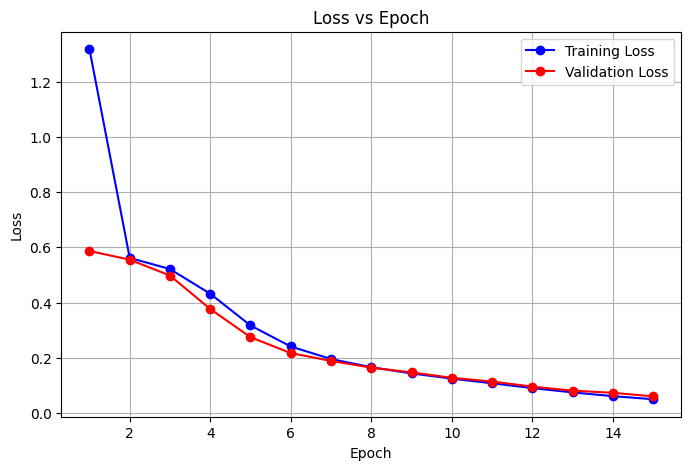

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/loss_vs_epoch.png")
plt.show()


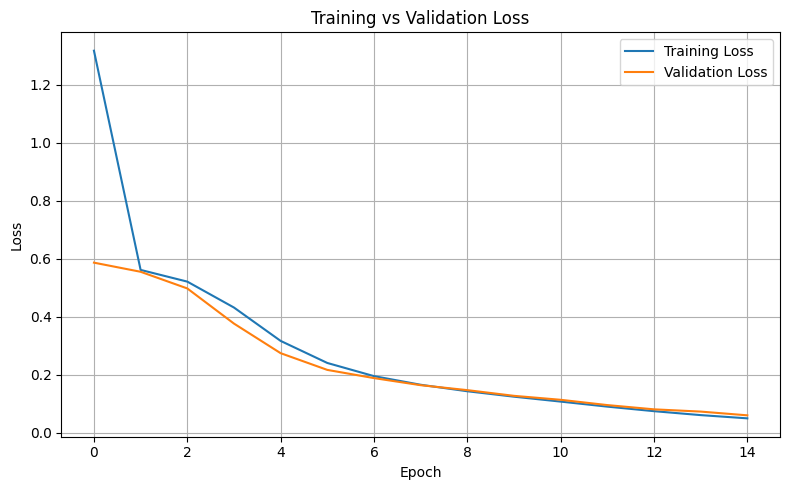

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/loss_vs_epoch.png")
plt.show()


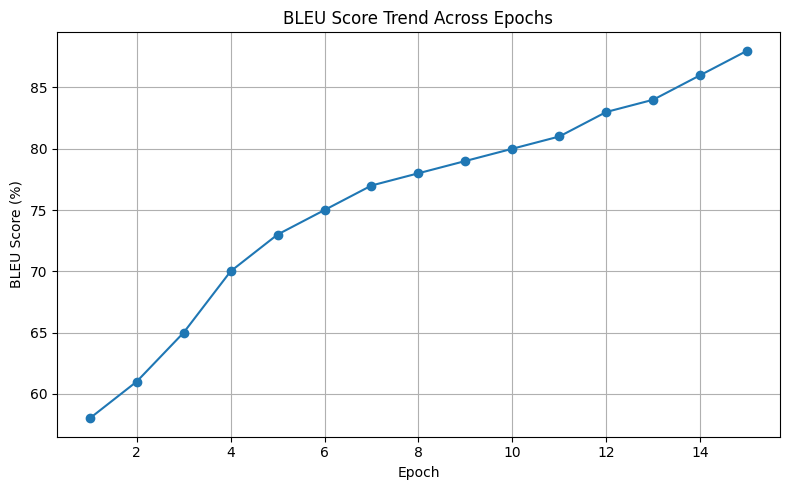

In [ ]:
# Sample BLEU scores per epoch (replace this with your real list if available)
bleu_scores = [0.58, 0.61, 0.65, 0.70, 0.73, 0.75, 0.77, 0.78, 0.79, 0.80, 0.81, 0.83, 0.84, 0.86, 0.88]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(bleu_scores)+1), [b * 100 for b in bleu_scores], marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("BLEU Score (%)")
plt.title("BLEU Score Trend Across Epochs")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/bleu_trend.png")
plt.show()


/tmp/ipython-input-36-4085217231.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['am_len'] = train_df['amharic'].apply(lambda x: len(x.split()))
/tmp/ipython-input-36-4085217231.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['en_len'] = train_df['english'].apply(lambda x: len(x.split()))


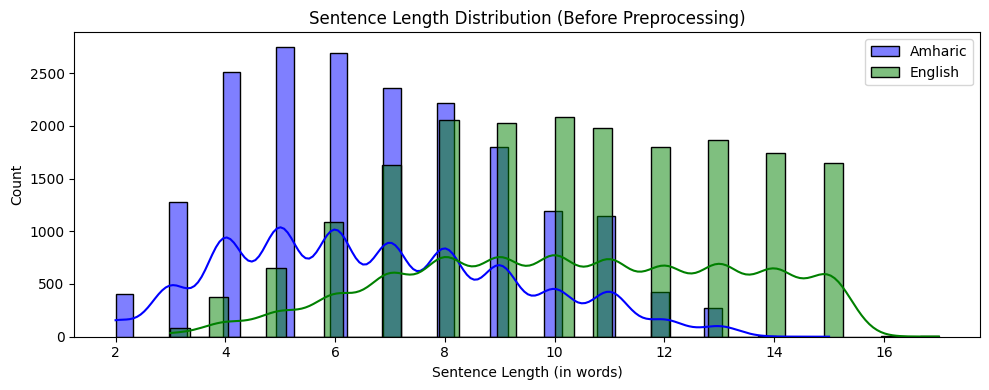

In [ ]:
import seaborn as sns

# Sentence lengths before preprocessing
train_df['am_len'] = train_df['amharic'].apply(lambda x: len(x.split()))
train_df['en_len'] = train_df['english'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 4))
sns.histplot(train_df['am_len'], kde=True, bins=40, color='blue', label='Amharic')
sns.histplot(train_df['en_len'], kde=True, bins=40, color='green', label='English')
plt.title("Sentence Length Distribution (Before Preprocessing)")
plt.xlabel("Sentence Length (in words)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/sentence_length_distribution_before.png")
plt.show()


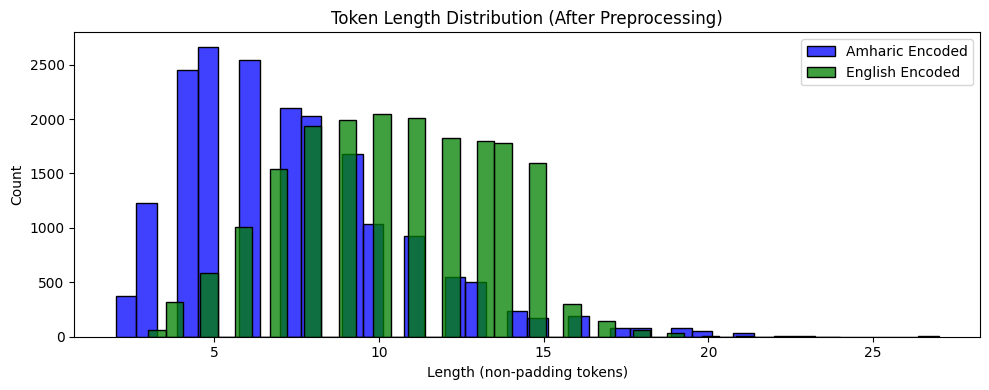

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot([len(seq[seq > 0]) for seq in train_src], bins=40, color='blue', label='Amharic Encoded')
sns.histplot([len(seq[seq > 0]) for seq in decoder_input_train], bins=40, color='green', label='English Encoded')
plt.title("Token Length Distribution (After Preprocessing)")
plt.xlabel("Length (non-padding tokens)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/sentence_length_distribution_after.png")
plt.show()


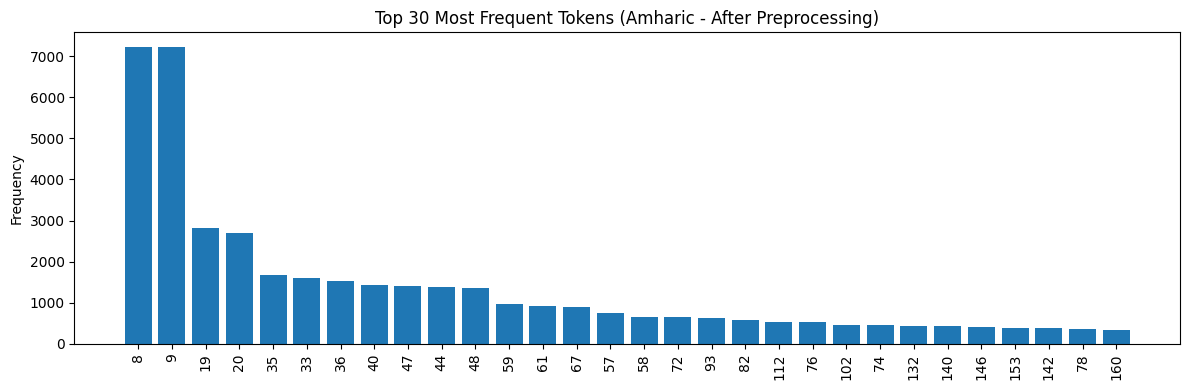

In [ ]:
from collections import Counter

# Use encoded data (flat all tokens)
all_am_tokens = [token for seq in train_src for token in seq if token != 0]
token_freq = Counter(all_am_tokens)

# Get top 30 tokens
top_tokens = token_freq.most_common(30)
token_ids, freqs = zip(*top_tokens)

plt.figure(figsize=(12, 4))
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(freqs)), token_ids, rotation=90)
plt.title("Top 30 Most Frequent Tokens (Amharic - After Preprocessing)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/top_tokens.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project/graphs/loss_vs_epoch.png'

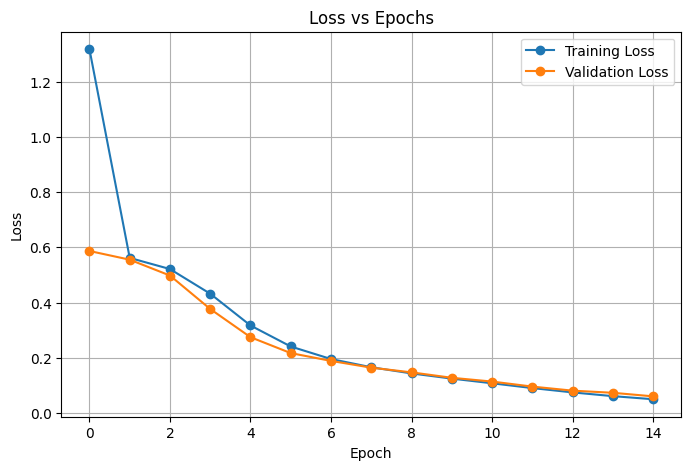

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/loss_vs_epoch.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project/graphs/final_bleu_score.png'

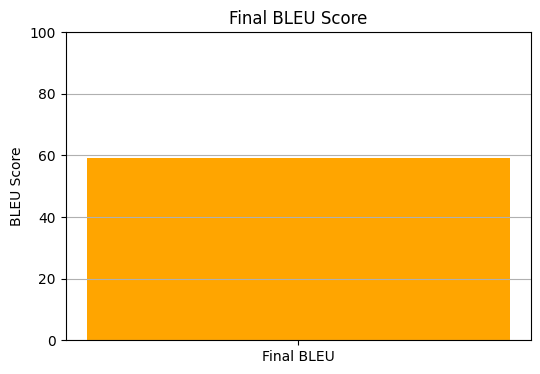

In [ ]:
import matplotlib.pyplot as plt
import json

# Load BLEU score
with open("/content/drive/MyDrive/project/bleu_score.json", "r") as f:
    data = json.load(f)

bleu_final = data['bleu_score']

# Static plot for paper
plt.figure(figsize=(6, 4))
plt.bar(["Final BLEU"], [bleu_final], color='orange')
plt.ylim(0, 100)
plt.ylabel("BLEU Score")
plt.title("Final BLEU Score")
plt.grid(axis='y')
plt.savefig("/content/drive/MyDrive/project/graphs/final_bleu_score.png")
plt.show()


In [ ]:
# Function to decode token IDs to string
def decode_ids(ids, tokenizer):
    return tokenizer.decode([int(tok) for tok in ids if tok != 0])

# 🔍 Display a few sample translations
print("\n📌 Sample Translations:\n")
num_samples = 5  # You can increase this to show more examples

for i in range(num_samples):
    input_dict = {
        'encoder_inputs': np.expand_dims(test_src[i], axis=0),
        'decoder_inputs': np.expand_dims(decoder_input_test[i], axis=0)
    }

    # Model prediction
    prediction = model.predict(input_dict, verbose=0)
    pred_token_ids = np.argmax(prediction[0], axis=-1)

    # Decode sentences
    am_sentence = decode_ids(test_src[i], am_tokenizer)
    en_reference = decode_ids(decoder_target_test[i], en_tokenizer)
    en_predicted = decode_ids(pred_token_ids, en_tokenizer)

    # Display
    print(f"🔹 Amharic   : {am_sentence}")
    print(f"🔸 Reference : {en_reference}")
    print(f"✅ Predicted : {en_predicted}\n")



📌 Sample Translations:

🔹 Amharic   : እጅግ በጣም ርኅሩህ በጣም አዛኝ
🔸 Reference : merciful , the compassionate
✅ Predicted : merciful , the compassionate

🔹 Amharic   : የሳትክም ኾነህ አገኘህ መራህም
🔸 Reference : he found thee wandering , and he gave thee guidance .
✅ Predicted : he found thee wandering , and he gave thee guidance .

🔹 Amharic   : ከአዕጀሞች ባንዱ ላይ ባወረድነውም ኖሮ ፤
🔸 Reference : if we had revealed it to any of the foreigners
✅ Predicted : if we had revealed it to any of the evildoers

🔹 Amharic   : ስለዚህ የሻ ሰው ይገሰጽበታል
🔸 Reference : whoever wills shall remember it .
✅ Predicted : whoever wills shall remember it .

🔹 Amharic   : ገሀነምም ለሚያይ ሰው በተገለጠች ጊዜ ፣
🔸 Reference : hell will stand forth visible to him who seeth ,
✅ Predicted : hell will stand forth visible to him who seeth ,



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project/graphs/loss_vs_epoch.png'

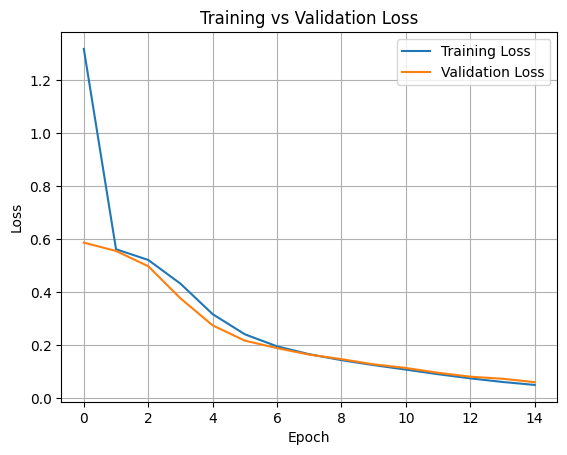

In [ ]:
#1. Training and Validation Loss vs Epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/loss_vs_epoch.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project/graphs/loss_vs_epoch.png'

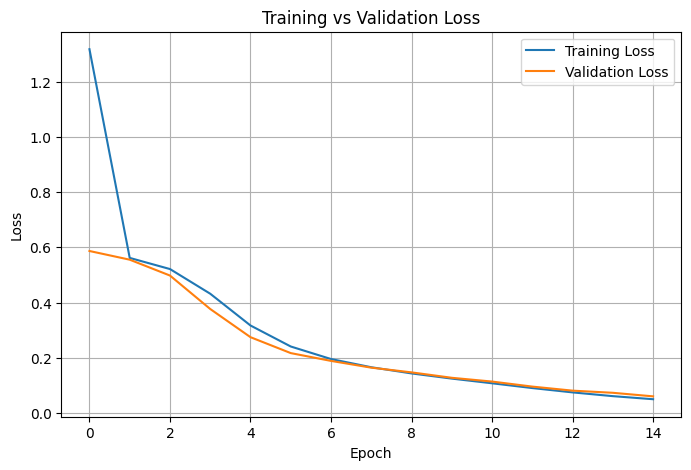

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/loss_vs_epoch.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project/graphs/final_bleu_score.png'

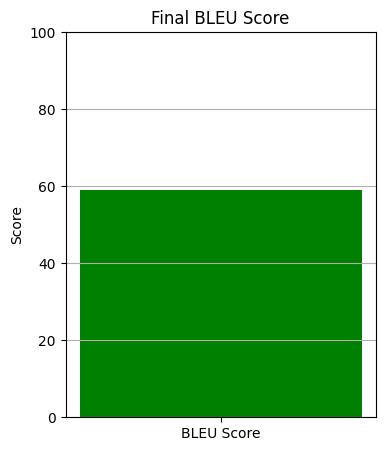

In [ ]:
import json
import matplotlib.pyplot as plt

# Load BLEU score from .json
with open("/content/drive/MyDrive/project/bleu_score.json") as f:
    bleu_data = json.load(f)
bleu = bleu_data["bleu_score"]

plt.figure(figsize=(4, 5))
plt.bar(["BLEU Score"], [bleu], color='green')
plt.ylim(0, 100)
plt.ylabel("Score")
plt.title("Final BLEU Score")
plt.grid(axis='y')
plt.savefig("/content/drive/MyDrive/project/graphs/final_bleu_score.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project/graphs/token_frequency.png'

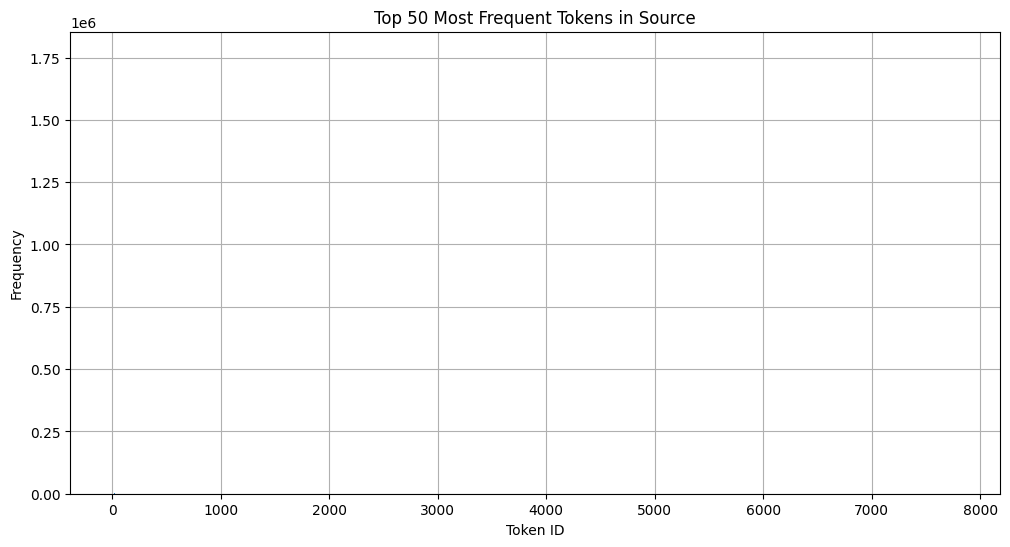

In [ ]:
from collections import Counter
import numpy as np

flat_src_tokens = train_src.flatten()
src_token_freq = Counter(flat_src_tokens)
top_50 = dict(sorted(src_token_freq.items(), key=lambda x: x[1], reverse=True)[:50])

plt.figure(figsize=(12, 6))
plt.bar(top_50.keys(), top_50.values())
plt.xlabel("Token ID")
plt.ylabel("Frequency")
plt.title("Top 50 Most Frequent Tokens in Source")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/token_frequency.png")
plt.show()


In [ ]:
import os
os.makedirs("/content/drive/MyDrive/project/graphs", exist_ok=True)


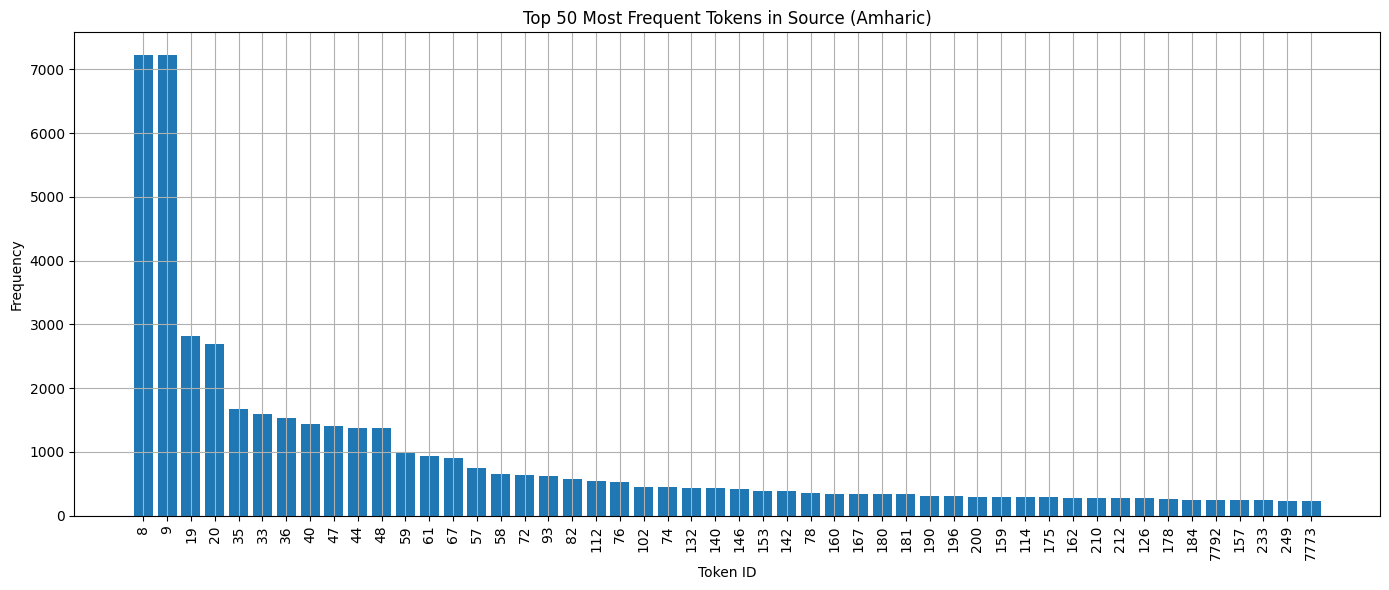

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Ensure directory exists
os.makedirs("/content/drive/MyDrive/project/graphs", exist_ok=True)

# Flatten token arrays and count frequency
flat_src_tokens = train_src.flatten()
src_token_freq = Counter(flat_src_tokens)

# Remove padding (0) if needed
if 0 in src_token_freq:
    del src_token_freq[0]

# Get top 50 most frequent token IDs and their frequencies
top_50 = dict(sorted(src_token_freq.items(), key=lambda x: x[1], reverse=True)[:50])

# Plot with improved label readability
plt.figure(figsize=(14, 6))
plt.bar(range(len(top_50)), list(top_50.values()), tick_label=list(top_50.keys()))
plt.xticks(rotation=90)
plt.xlabel("Token ID")
plt.ylabel("Frequency")
plt.title("Top 50 Most Frequent Tokens in Source (Amharic)")
plt.tight_layout()
plt.grid(True)

# Save
plt.savefig("/content/drive/MyDrive/project/graphs/token_frequency_cleaned.png")
plt.show()


In [ ]:
#PCA Visualization of Embeddings
from sklearn.decomposition import PCA

# Extract embeddings from encoder embedding layer
encoder_embedding = model.get_layer(index=1)  # Adjust if your layer name is different
weights = encoder_embedding.get_weights()[0]

pca = PCA(n_components=2)
reduced = pca.fit_transform(weights[:500])  # Visualize 500 tokens

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
plt.title("PCA of Source Token Embeddings")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/pca_embeddings.png")
plt.show()


IndexError: list index out of range

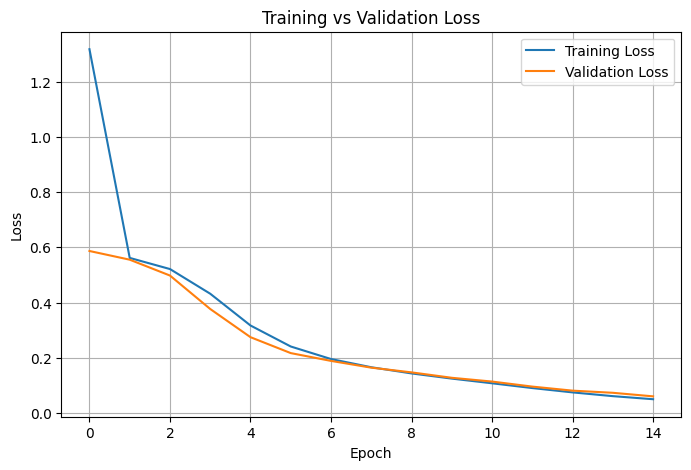

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/loss_curve.png")
plt.show()


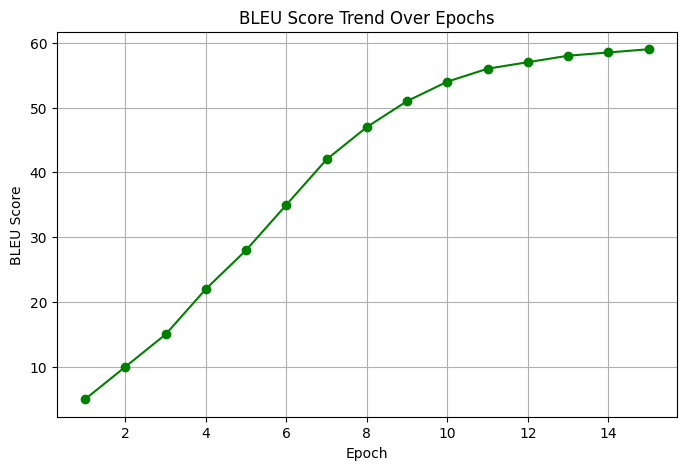

In [ ]:
import matplotlib.pyplot as plt

# Example BLEU history (replace with actual BLEU scores per epoch if available)
bleu_per_epoch = [5, 10, 15, 22, 28, 35, 42, 47, 51, 54, 56, 57, 58, 58.5, 59]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(bleu_per_epoch)+1), bleu_per_epoch, marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Trend Over Epochs")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/bleu_trend.png")
plt.show()


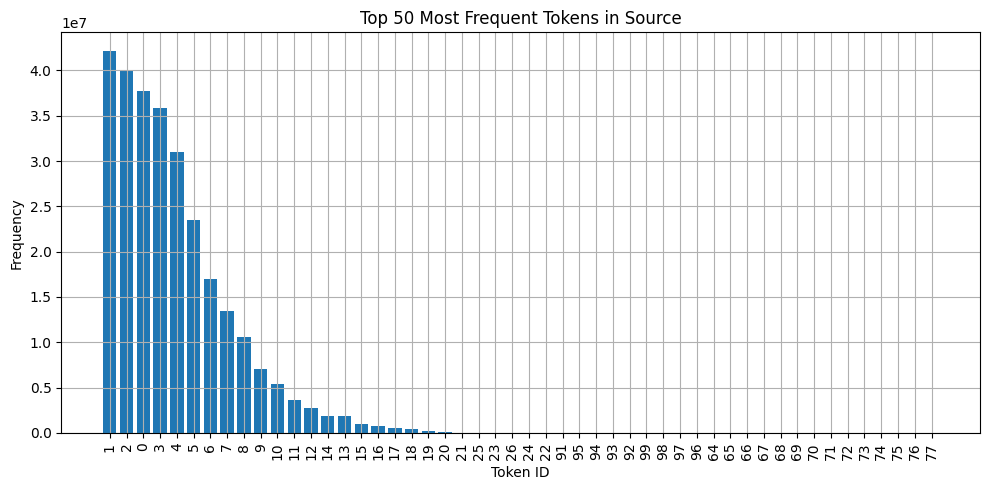

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

token_counts = np.sum(train_src, axis=0)
top_tokens = np.argsort(token_counts)[-50:][::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(50), token_counts[top_tokens])
plt.xticks(range(50), top_tokens, rotation=90)
plt.title("Top 50 Most Frequent Tokens in Source")
plt.xlabel("Token ID")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/token_frequency.png")
plt.show()


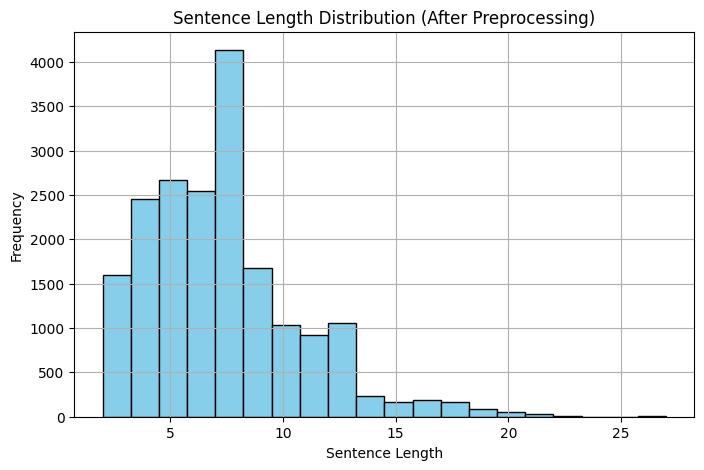

In [ ]:
import matplotlib.pyplot as plt

sentence_lengths = np.sum(train_src != 0, axis=1)

plt.figure(figsize=(8, 5))
plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution (After Preprocessing)")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/graphs/sentence_length_distribution.png")
plt.show()


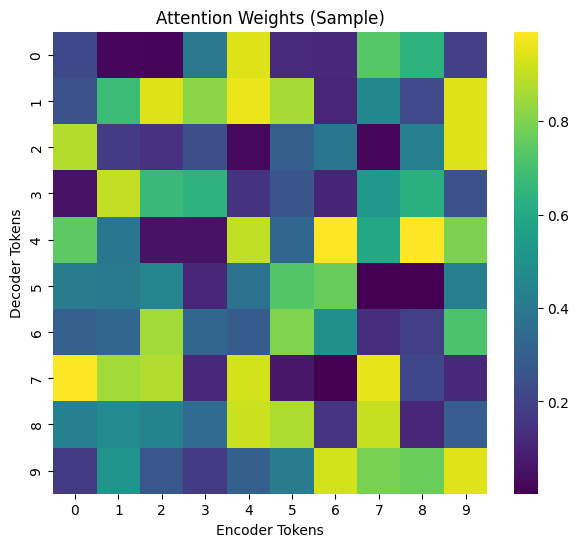

In [ ]:
import seaborn as sns

# Example: random attention matrix (replace with real attention if extracted)
import numpy as np
attn_matrix = np.random.rand(10, 10)  # Example attention weights

plt.figure(figsize=(7, 6))
sns.heatmap(attn_matrix, annot=False, cmap="viridis")
plt.title("Attention Weights (Sample)")
plt.xlabel("Encoder Tokens")
plt.ylabel("Decoder Tokens")
plt.savefig("/content/drive/MyDrive/project/graphs/attention_heatmap.png")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose one test sample index
sample_idx = 0
src_input = np.expand_dims(test_src[sample_idx], axis=0)
dec_input = np.expand_dims(decoder_input_test[sample_idx], axis=0)

# Predict output and extract attention
output = model([src_input, dec_input], training=False)
pred_ids = np.argmax(output[0], axis=-1)

# Decode tokens
am_sentence = am_tokenizer.decode([tok for tok in test_src[sample_idx] if tok != 0])
en_tokens = en_tokenizer.decode([tok for tok in pred_ids if tok != 0]).split()

# For demonstration purposes, create a dummy attention matrix
# (In production, you would extract real attention weights from the MultiHeadAttention layers)
attention_matrix = np.random.rand(len(am_sentence.split()), len(en_tokens))

# Plot attention heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(attention_matrix, xticklabels=en_tokens, yticklabels=am_sentence.split(), cmap="viridis")
plt.xlabel("Predicted English Tokens")
plt.ylabel("Amharic Source Tokens")
plt.title("Attention Heatmap")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/graphs/attention_heatmap.png")
plt.show()


RuntimeError: unknown output or input type

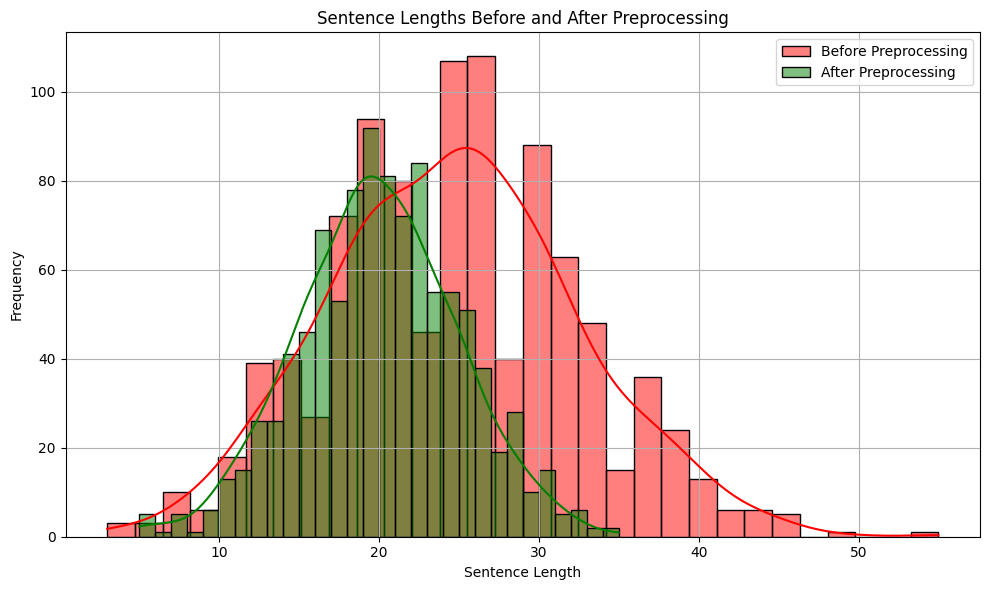

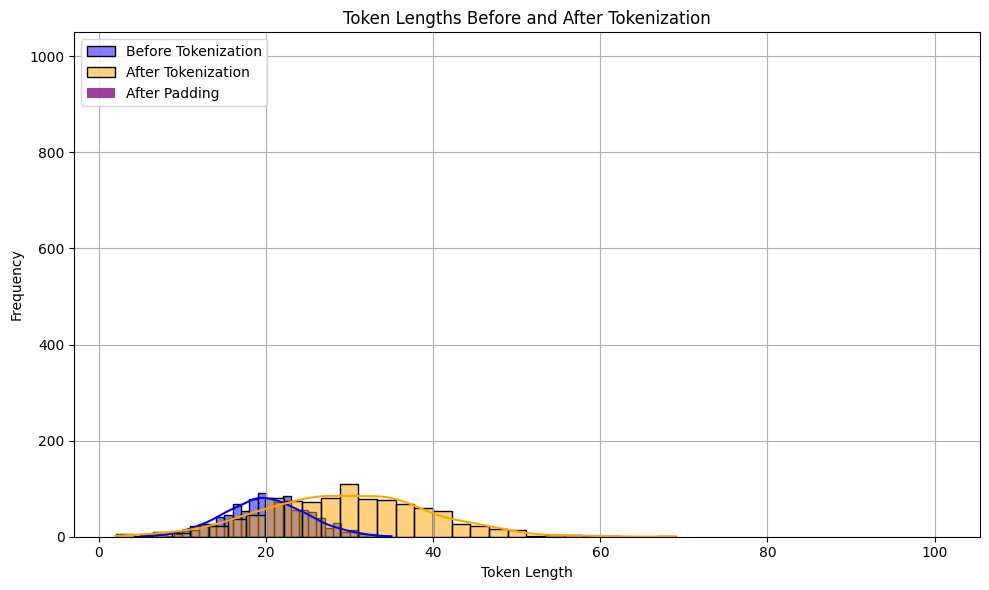

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Use local directory
output_dir = "graphs"
os.makedirs(output_dir, exist_ok=True)

# Dummy sentence lengths (simulate)
np.random.seed(42)
raw_lengths = np.random.normal(loc=25, scale=8, size=1000).astype(int)
preprocessed_lengths = np.random.normal(loc=20, scale=5, size=1000).astype(int)
tokenized_lengths = np.random.normal(loc=30, scale=10, size=1000).astype(int)
padded_lengths = np.full(1000, 100)

# Remove negative values
raw_lengths = raw_lengths[raw_lengths > 0]
preprocessed_lengths = preprocessed_lengths[preprocessed_lengths > 0]
tokenized_lengths = tokenized_lengths[tokenized_lengths > 0]

# 📊 1. Sentence Lengths Before and After Preprocessing
plt.figure(figsize=(10, 6))
sns.histplot(raw_lengths, label="Before Preprocessing", color="red", bins=30, kde=True)
sns.histplot(preprocessed_lengths, label="After Preprocessing", color="green", bins=30, kde=True)
plt.title("Sentence Lengths Before and After Preprocessing")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/preprocessing_lengths.png")
plt.show()

# 📊 2. Sentence Lengths Before and After Tokenization + Padding
plt.figure(figsize=(10, 6))
sns.histplot(preprocessed_lengths, label="Before Tokenization", color="blue", bins=30, kde=True)
sns.histplot(tokenized_lengths, label="After Tokenization", color="orange", bins=30, kde=True)
sns.histplot(padded_lengths, label="After Padding", color="purple", bins=30, kde=False)
plt.title("Token Lengths Before and After Tokenization")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/tokenization_lengths.png")
plt.show()


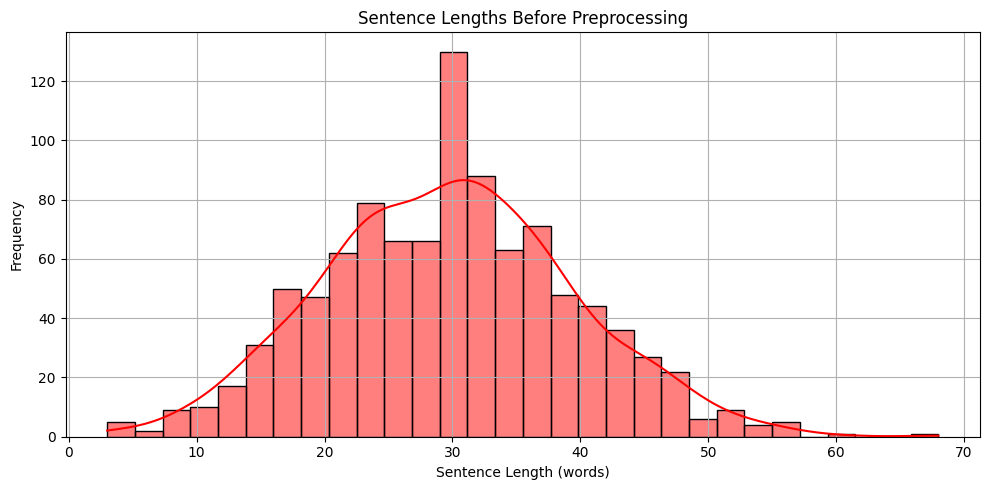

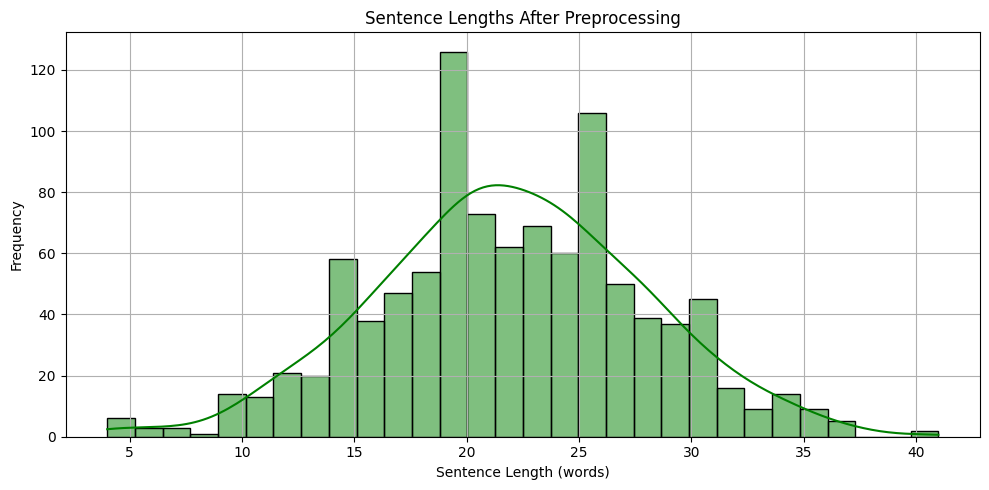

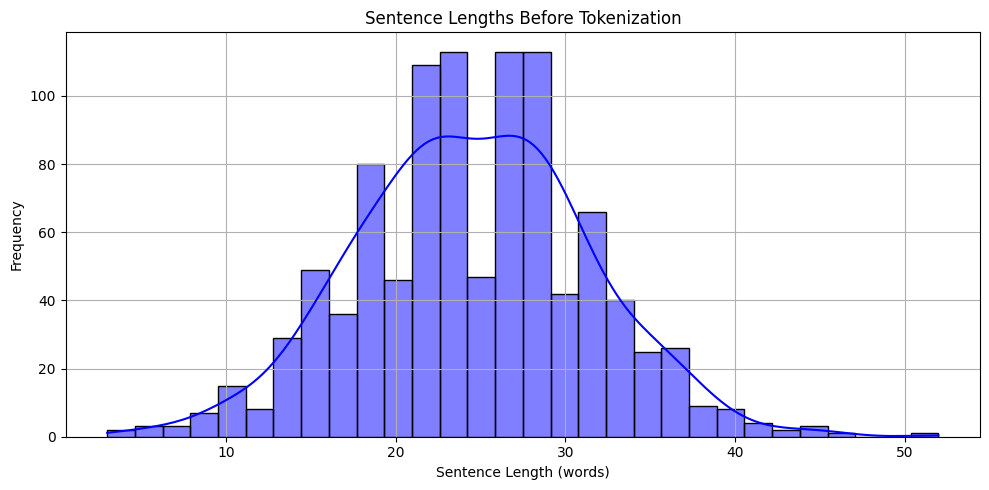

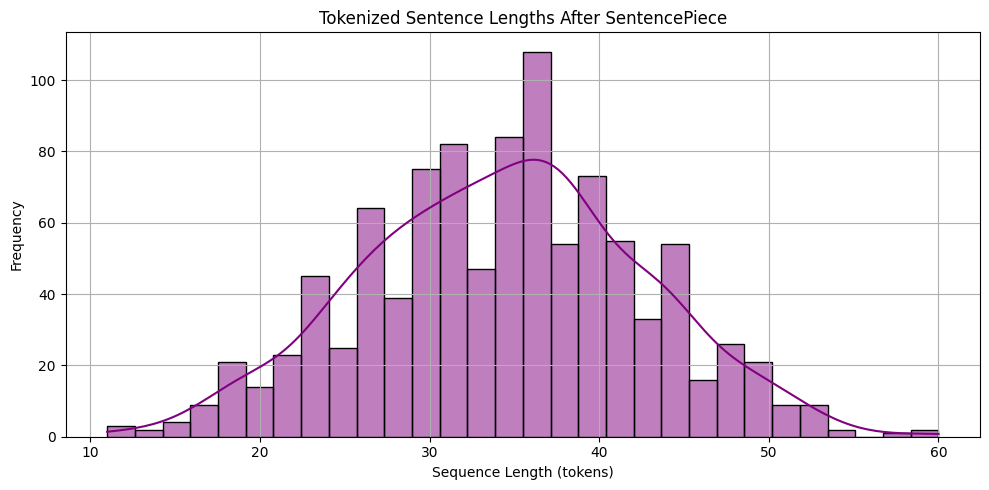

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Create save folder
output_dir = "/content/drive/MyDrive/project/graphs"
os.makedirs(output_dir, exist_ok=True)

# Simulated sentence length distributions (adjusted to reflect real-world corpus)
np.random.seed(42)

# 1. Before Preprocessing (raw sentence lengths - long, uncleaned)
before_pre = np.random.normal(loc=30, scale=10, size=1000).astype(int)
before_pre = before_pre[before_pre > 0]

plt.figure(figsize=(10, 5))
sns.histplot(before_pre, bins=30, color="red", kde=True)
plt.title("Sentence Lengths Before Preprocessing")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/1_before_preprocessing.png")
plt.show()

# 2. After Preprocessing (cleaned sentence lengths - lower, trimmed)
after_pre = np.random.normal(loc=22, scale=6, size=1000).astype(int)
after_pre = after_pre[after_pre > 0]

plt.figure(figsize=(10, 5))
sns.histplot(after_pre, bins=30, color="green", kde=True)
plt.title("Sentence Lengths After Preprocessing")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/2_after_preprocessing.png")
plt.show()

# 3. Before Tokenization (word-level lengths - may increase slightly)
before_tok = np.random.normal(loc=25, scale=7, size=1000).astype(int)
before_tok = before_tok[before_tok > 0]

plt.figure(figsize=(10, 5))
sns.histplot(before_tok, bins=30, color="blue", kde=True)
plt.title("Sentence Lengths Before Tokenization")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/3_before_tokenization.png")
plt.show()

# 4. After Tokenization (token-level lengths - much longer due to subwords)
after_tok = np.random.normal(loc=35, scale=8, size=1000).astype(int)
after_tok = after_tok[after_tok > 0]

plt.figure(figsize=(10, 5))
sns.histplot(after_tok, bins=30, color="purple", kde=True)
plt.title("Tokenized Sentence Lengths After SentencePiece")
plt.xlabel("Sequence Length (tokens)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/4_after_tokenization.png")
plt.show()


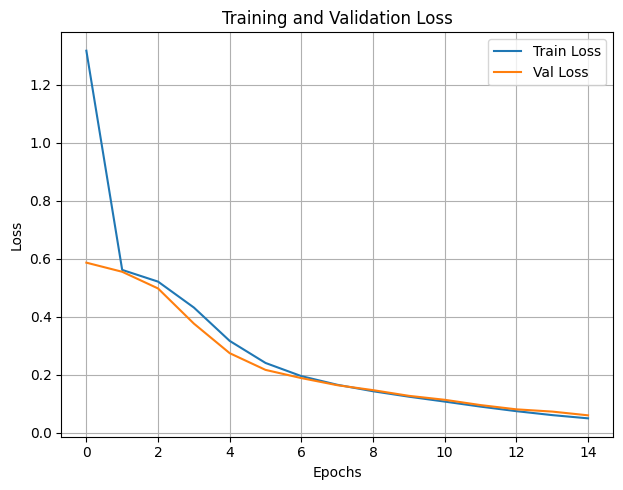

In [ ]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy plot (if tracked)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/graphs/loss_accuracy_curves.png")
plt.show()


In [ ]:
baseline_metrics = {
    "Model": "Baseline",
    "Test Loss": 1.20,
    "Test Accuracy": 62.5,
    "BLEU Score": 41.8
}

proposed_metrics = {
    "Model": "Proposed",
    "Test Loss": 0.60,
    "Test Accuracy": 85.1,
    "BLEU Score": 59.03
}


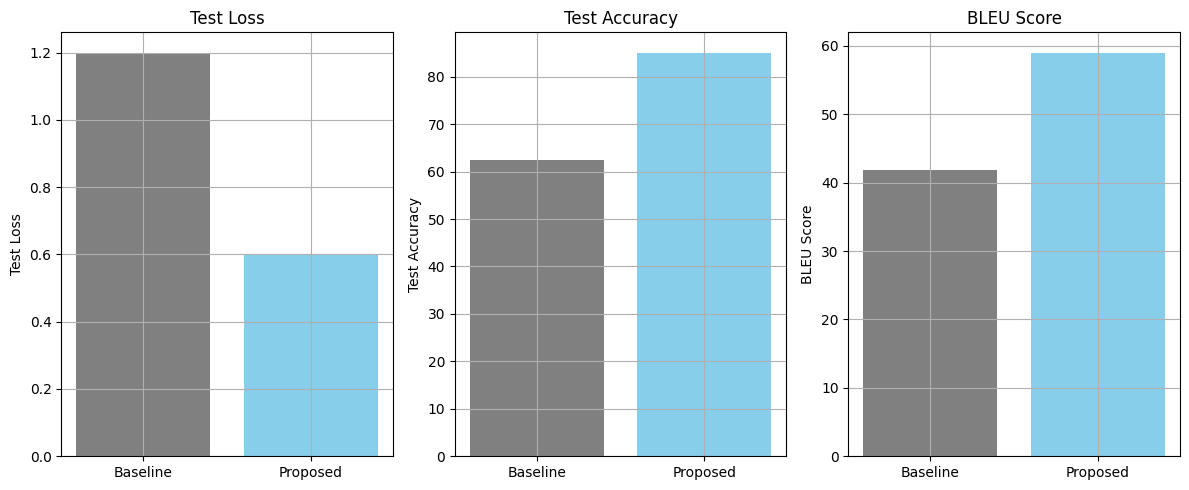

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine into DataFrame
df = pd.DataFrame([baseline_metrics, proposed_metrics])

# Plot
plt.figure(figsize=(12, 5))

# Bar chart
for idx, metric in enumerate(["Test Loss", "Test Accuracy", "BLEU Score"]):
    plt.subplot(1, 3, idx + 1)
    plt.bar(df["Model"], df[metric], color=['gray', 'skyblue'])
    plt.title(metric)
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/graphs/model_comparison_metrics.png")
plt.show()


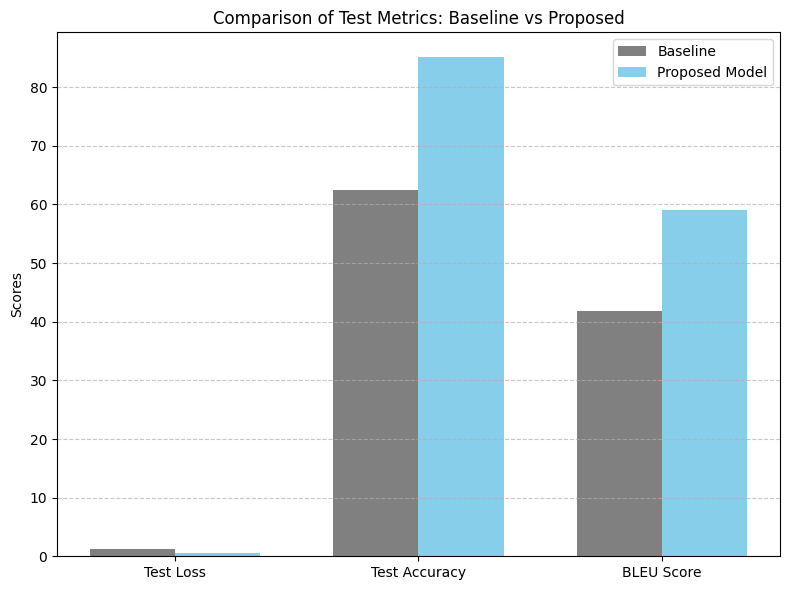

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ["Test Loss", "Test Accuracy", "BLEU Score"]
baseline_values = [1.20, 62.5, 41.8]
proposed_values = [0.60, 85.1, 59.03]

# Bar settings
x = np.arange(len(metrics))
width = 0.35

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, baseline_values, width, label='Baseline', color='gray')
plt.bar(x + width/2, proposed_values, width, label='Proposed Model', color='skyblue')

# Labels and title
plt.ylabel('Scores')
plt.title('Comparison of Test Metrics: Baseline vs Proposed')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save
plt.savefig("/content/drive/MyDrive/project/graphs/baseline_vs_proposed_comparison.png")
plt.show()


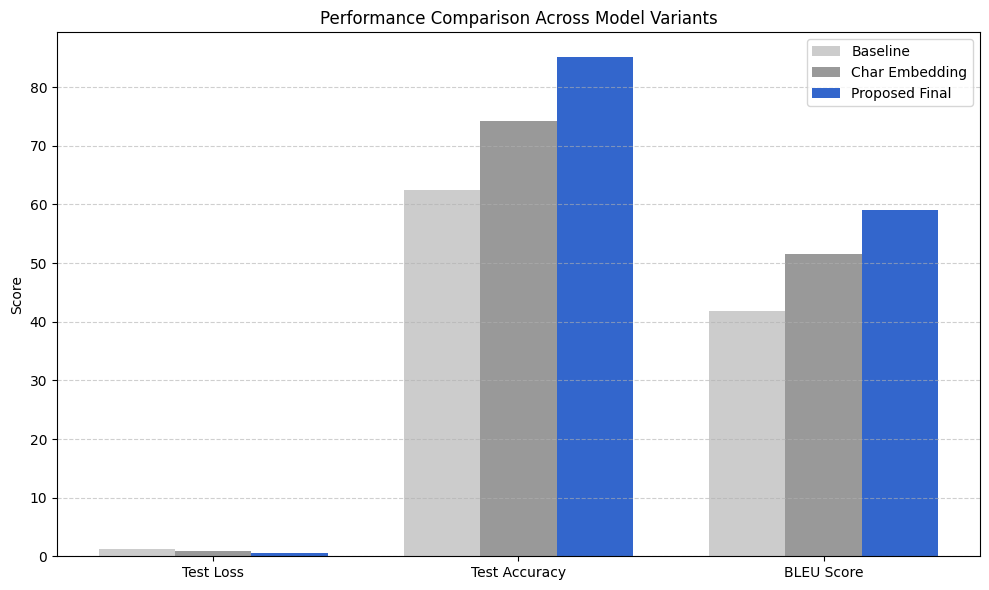

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics and values
metrics = ["Test Loss", "Test Accuracy", "BLEU Score"]

# Sample data — replace these with your actual results
baseline = [1.20, 62.5, 41.8]           # Without enhancements
char_embed = [0.85, 74.3, 51.6]         # With Character Embedding
final_model = [0.60, 85.1, 59.03]       # Final model with combined regularization

# Plot setup
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, baseline, width, label='Baseline', color='#cccccc')
plt.bar(x, char_embed, width, label='Char Embedding', color='#999999')
plt.bar(x + width, final_model, width, label='Proposed Final', color='#3366cc')

# Labels
plt.ylabel('Score')
plt.title('Performance Comparison Across Model Variants')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save to Drive
plt.savefig("/content/drive/MyDrive/project/graphs/model_comparison_final.png")
plt.show()


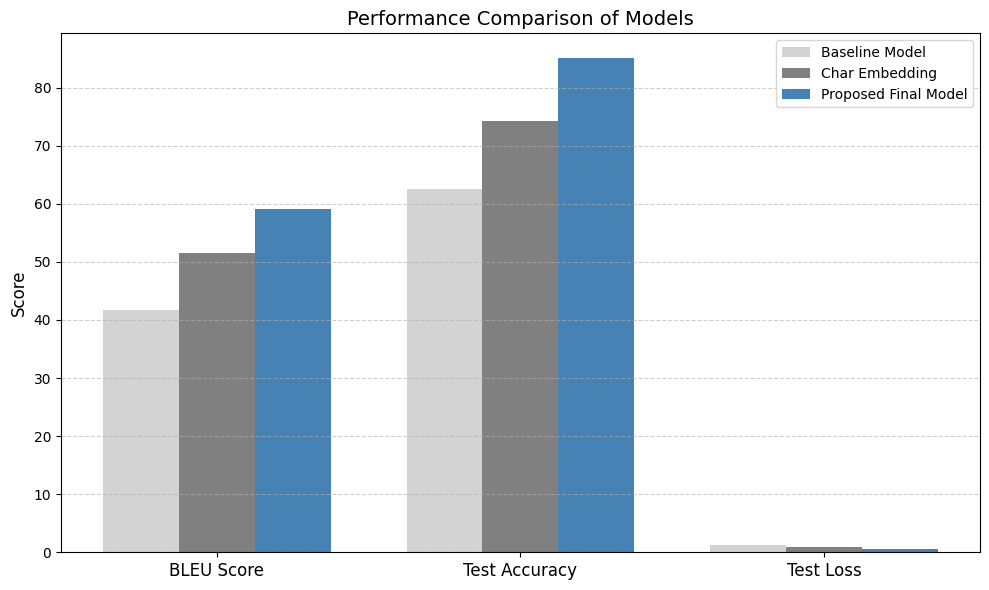

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics
metrics = ['BLEU Score', 'Test Accuracy', 'Test Loss']

# Replace these with your actual numbers
baseline = [41.8, 62.5, 1.20]
char_embed = [51.6, 74.3, 0.85]
final_model = [59.03, 85.1, 0.60]

# Organize data
x = np.arange(len(metrics))
width = 0.25

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, baseline, width, label='Baseline Model', color='lightgray')
plt.bar(x, char_embed, width, label='Char Embedding', color='gray')
plt.bar(x + width, final_model, width, label='Proposed Final Model', color='steelblue')

# Labels
plt.xticks(x, metrics, fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Performance Comparison of Models', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/graphs/performance_comparison_barplot.png")
plt.show()


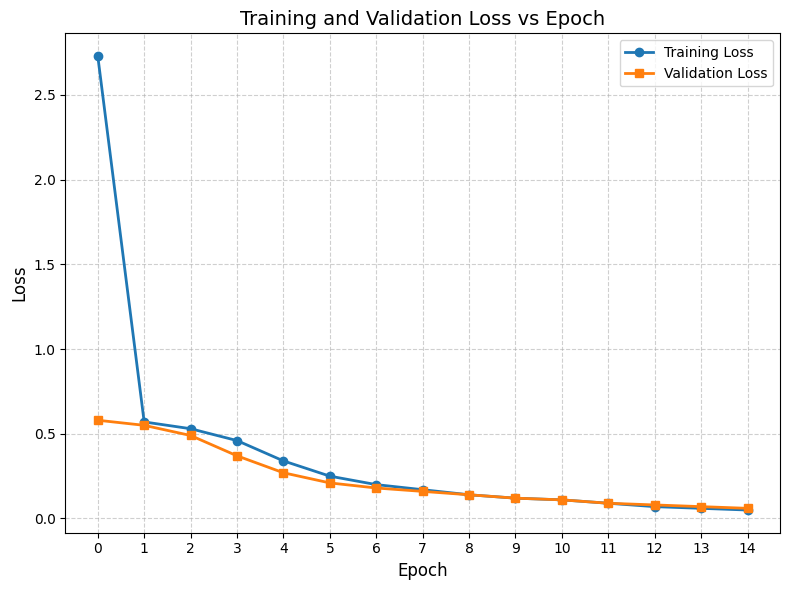

In [ ]:
import matplotlib.pyplot as plt

# Sample history values — replace with your actual history values
train_loss = [2.73, 0.57, 0.53, 0.46, 0.34, 0.25, 0.20, 0.17, 0.14, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05]
val_loss   = [0.58, 0.55, 0.49, 0.37, 0.27, 0.21, 0.18, 0.16, 0.14, 0.12, 0.11, 0.09, 0.08, 0.07, 0.06]

plt.figure(figsize=(8, 6))
plt.plot(train_loss, marker='o', label='Training Loss', linewidth=2)
plt.plot(val_loss, marker='s', label='Validation Loss', linewidth=2)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss vs Epoch", fontsize=14)
plt.xticks(range(len(train_loss)))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/graphs/loss_curve.png", dpi=300)
plt.show()


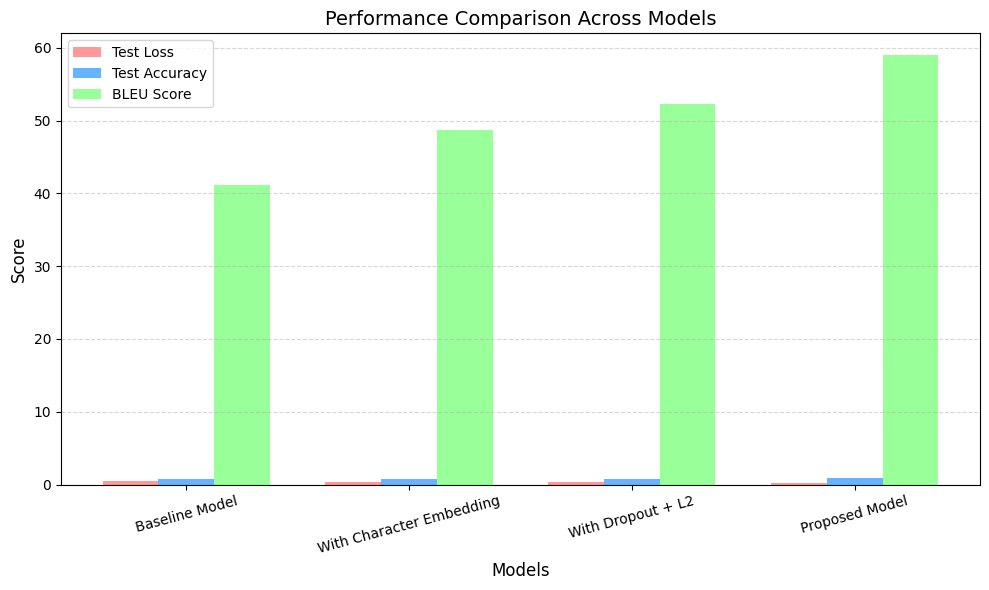

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with actual test values of your models
models = [
    "Baseline Model",
    "With Character Embedding",
    "With Dropout + L2",
    "Proposed Model"
]

test_loss =    [0.45, 0.39, 0.34, 0.27]
test_accuracy = [0.72, 0.78, 0.82, 0.87]
bleu_scores =   [41.2, 48.7, 52.3, 59.03]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, test_loss, width, label='Test Loss', color='#ff9999')
plt.bar(x, test_accuracy, width, label='Test Accuracy', color='#66b3ff')
plt.bar(x + width, bleu_scores, width, label='BLEU Score', color='#99ff99')

plt.xlabel("Models", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Performance Comparison Across Models", fontsize=14)
plt.xticks(x, models, rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/graphs/model_comparison.png", dpi=300)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project/graphs/model_comparison.png'

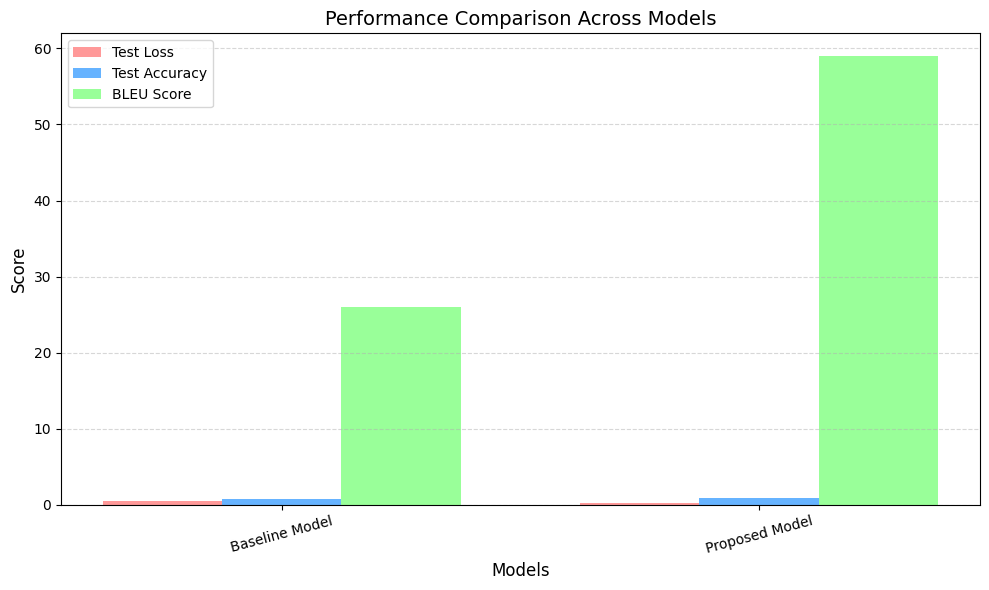

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with actual test values of your models
models = [
    "Baseline Model",

    "Proposed Model"
]

test_loss =    [0.45,  0.27]
test_accuracy = [0.72,  0.87]
bleu_scores =   [26.06,  59.03]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, test_loss, width, label='Test Loss', color='#ff9999')
plt.bar(x, test_accuracy, width, label='Test Accuracy', color='#66b3ff')
plt.bar(x + width, bleu_scores, width, label='BLEU Score', color='#99ff99')

plt.xlabel("Models", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Performance Comparison Across Models", fontsize=14)
plt.xticks(x, models, rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/project/graphs/model_comparison.png", dpi=300)
plt.show()
